In [8]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BASE_DIR = "C:/python/SKIN_CANCER/dataset/"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

print("Class Mapping:", train_generator.class_indices)


Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


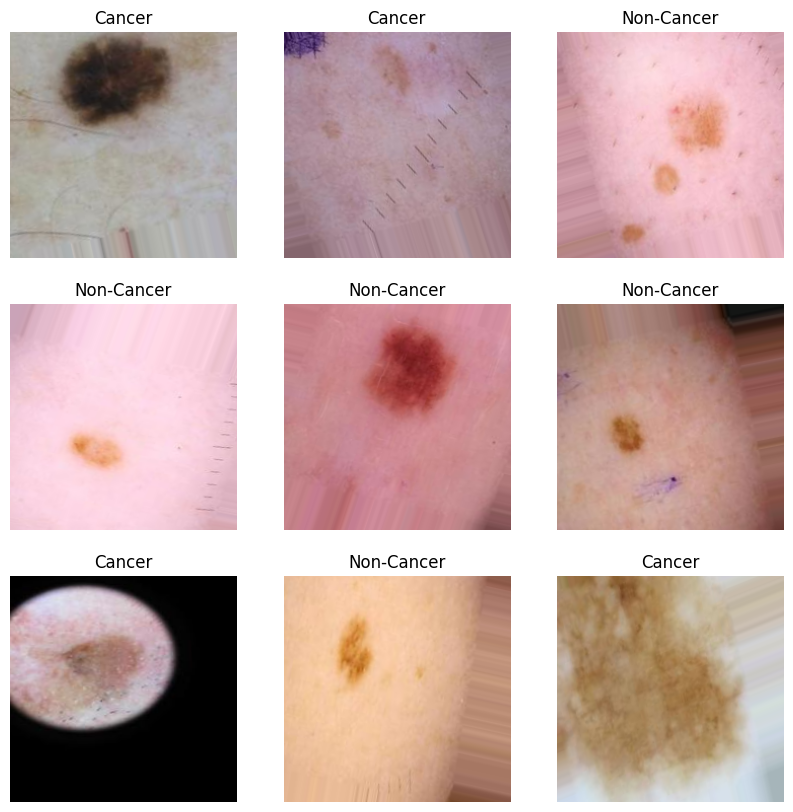

In [5]:
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()

plot_images(train_generator)

In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # 1st convolution block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    # 2nd convolution block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # 3rd convolution block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # classifiaction
    layers.Flatten(),

    # fully connected part
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
])


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

C:\python\SKIN_CANCER\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30, #number of epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

C:\python\SKIN_CANCER\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.7194 - loss: 0.6853 - val_accuracy: 0.8301 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 7:32 1s/step - accuracy: 0.8750 - loss: 0.3766

C:\python\SKIN_CANCER\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8750 - loss: 0.3766 - val_accuracy: 0.7954 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 1500s 4s/step - accuracy: 0.8184 - loss: 0.4111 - val_accuracy: 0.8407 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8438 - loss: 0.3437 - val_accuracy: 0.8468 - val_loss: 0.3557 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 1201s 3s/step - accuracy: 0.8305 - loss: 0.3930 - val_accuracy: 0.7858 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6875 - loss: 0.4258 - val_accuracy: 0.7772 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.8352 - loss: 0.3728   
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
371/371 ━━━━━━━━━━━━━━━━━━━━ 9444s 26s/step - accuracy: 0.8353 - loss: 0.372

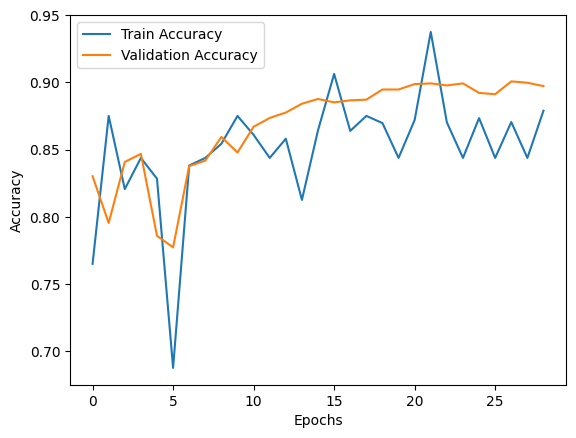

In [13]:
#save model
model.save("skin_cancer_cnn.h5");

#plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()




62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      1000
           1       0.50      0.54      0.52       984

    accuracy                           0.50      1984
   macro avg       0.50      0.50      0.50      1984
weighted avg       0.50      0.50      0.50      1984



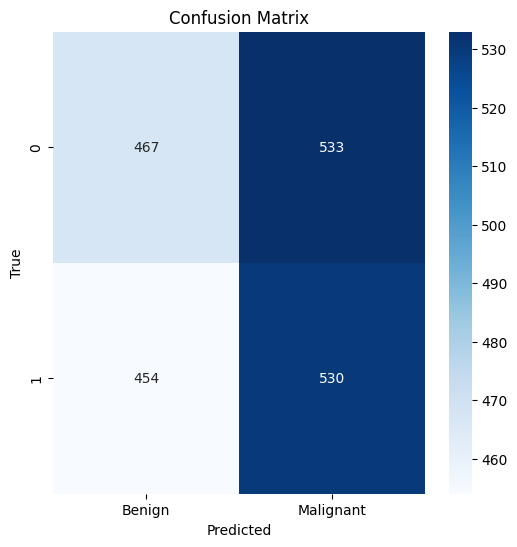

In [7]:
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
test_pred_labels = (test_pred > 0.5).astype("int32")

test_true_labels = test_generator.classes[:len(test_pred_labels)]

#classification report
print("Classification report:")
print(classification_report(test_true_labels, test_pred_labels))

#confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model("skin_cancer_cnn.h5")
def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    print("Prediction Value:", prediction)

    class_label = "Malignant" if prediction > 0.6 else "Benign"
    print("Predicted Label:", class_label)

    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Prediction Value: [[0.99975675]]
Predicted Label: Malignant


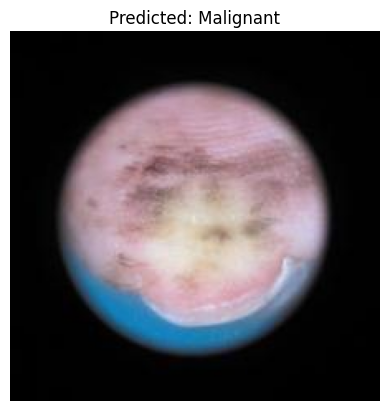

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction Value: [[0.80333465]]
Predicted Label: Malignant


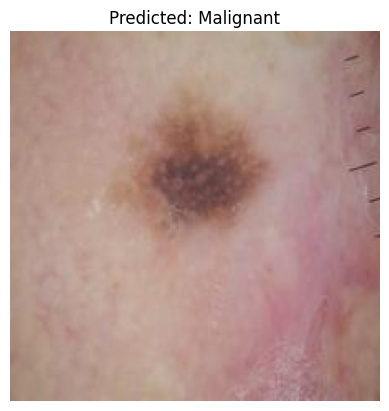

In [17]:
predict_skin_cancer("C:/python/SKIN_CANCER/dataset/test/Malignant/5615.jpg",model)
predict_skin_cancer("C:/python/SKIN_CANCER/dataset/train/Malignant/1002.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction Value: [[0.07575726]]
Predicted Label: Benign


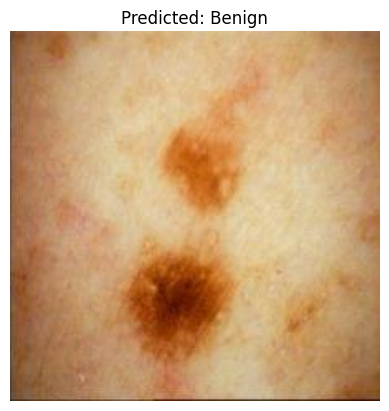

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction Value: [[0.00402294]]
Predicted Label: Benign


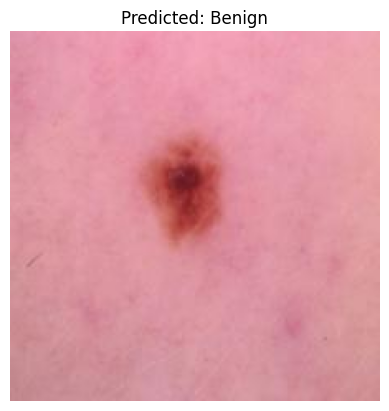

In [18]:
predict_skin_cancer("C:/python/SKIN_CANCER/dataset/test/Benign/6339.jpg", model) 
predict_skin_cancer("C:/python/SKIN_CANCER/dataset/train/Benign/1051.jpg", model)
